In [1]:
import time
import os
from os.path import join, exists
import numpy as np
import pandas as pd
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from tqdm import tqdm
import skimage.io
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import openslide

In [2]:
dataset_path = "/media/matthew/External/Kaggle/PANDA_Challenge"
train_image_path = join(dataset_path, "train_images")
train_mask_path = join(dataset_path, "train_label_masks")
patches_path = join(dataset_path, "extracted_patches")

In [3]:
train_df = pd.read_csv(join(dataset_path, 'train.csv'))
train_rad = train_df[train_df['data_provider'] == 'r']
train_kar = train_df[train_df['data_provider'] == 'k']
print(len(train_rad), len(train_kar))

5160 5456


In [4]:
class PatchSlicer:
    def __init__(self, wsi, step_size=32):
        self.wsi = wsi
        self.step_size = step_size
        self.x = 0
        self.y = 0

    def generator(self):
        self.width = self.wsi.shape[0]
        self.height = self.wsi.shape[1]
        while self.y + self.step_size < self.height:
            while self.x + self.step_size < self.width:
                yield self.wsi[self.x:self.x + self.step_size, self.y:self.y + self.step_size], (self.x, self.y)
                self.x += self.step_size
            self.x = 0
            self.y += self.step_size

In [80]:
data = []
for image_id,isup in tqdm(train_rad[['image_id','isup_grade']].values):
    image_path = join(train_image_path, image_id + '.tiff')
    mask_path = join(train_mask_path, image_id + '_mask.tiff')
    if not exists(mask_path): continue
    image = skimage.io.MultiImage(image_path)[-1]
    mask = skimage.io.MultiImage(mask_path)[-1]
    
    with openslide.OpenSlide(image_path) as l_image:
        lx, ly = l_image.level_dimensions[0]
    
    content = np.argwhere(np.sum(s_image, axis=2) != 765)
    top, left = np.min(content, axis=0)
    bottom, right = np.max(content, axis=0) + 1
    cropped = image[top:bottom, left:right]
    cropped_mask = mask[top:bottom, left:right, 0]
    
    sy, sx, sc = s_image.shape
    sf_y, sf_x = int(ly / sy), int(lx / sx)
    
    ps = PatchSlicer(cropped)
    patch_id = 0
    coords = []
    for patch, coord in ps.generator():
        if patch.mean() > 240: continue
        x, y = coord
        patch_mask = cropped_mask[x : x + 32, y : y + 32]
        label = 0
        uv, uc = np.unique(patch_mask, return_counts=True)
        for v, c in zip(uv, uc):
            if v in [3,4,5]:
                if (c / 1024.0) > 0.01: # More than 1%
                    label = isup
        x *= sf_x
        y *= sf_y
        data.append([image_id, patch_id, x, y, label])
        patch_id += 1







  0%|          | 0/5160 [00:00<?, ?it/s]





  0%|          | 2/5160 [00:00<05:02, 17.05it/s]





  0%|          | 5/5160 [00:00<04:39, 18.47it/s]





  0%|          | 7/5160 [00:00<04:35, 18.71it/s]





  0%|          | 9/5160 [00:00<04:52, 17.62it/s]





  0%|          | 12/5160 [00:00<04:44, 18.12it/s]





  0%|          | 14/5160 [00:00<05:02, 17.02it/s]





  0%|          | 16/5160 [00:00<05:04, 16.87it/s]





  0%|          | 18/5160 [00:01<05:08, 16.68it/s]





  0%|          | 20/5160 [00:01<04:54, 17.48it/s]





  0%|          | 22/5160 [00:01<04:45, 18.00it/s]





  0%|          | 25/5160 [00:01<04:31, 18.89it/s]





  1%|          | 27/5160 [00:01<04:46, 17.91it/s]





  1%|          | 30/5160 [00:01<04:35, 18.63it/s]





  1%|          | 32/5160 [00:01<04:39, 18.36it/s]





  1%|          | 34/5160 [00:01<04:49, 17.70it/s]





  1%|          | 36/5160 [00:01<04:48, 17.76it/s]





  1%|          | 38/5160 [00:02<05:05, 16.76it/s]





  1%|          | 

 10%|█         | 519/5160 [00:28<04:19, 17.87it/s]





 10%|█         | 522/5160 [00:29<04:13, 18.30it/s]





 10%|█         | 524/5160 [00:29<04:30, 17.14it/s]





 10%|█         | 526/5160 [00:29<04:44, 16.28it/s]





 10%|█         | 528/5160 [00:29<04:38, 16.65it/s]





 10%|█         | 530/5160 [00:29<04:27, 17.33it/s]





 10%|█         | 532/5160 [00:29<04:16, 18.02it/s]





 10%|█         | 535/5160 [00:29<04:01, 19.18it/s]





 10%|█         | 537/5160 [00:29<04:12, 18.33it/s]





 10%|█         | 539/5160 [00:30<04:17, 17.94it/s]





 10%|█         | 541/5160 [00:30<04:28, 17.20it/s]





 11%|█         | 543/5160 [00:30<04:32, 16.97it/s]





 11%|█         | 545/5160 [00:30<04:40, 16.47it/s]





 11%|█         | 547/5160 [00:30<04:53, 15.71it/s]





 11%|█         | 549/5160 [00:30<04:58, 15.47it/s]





 11%|█         | 552/5160 [00:30<04:40, 16.41it/s]





 11%|█         | 554/5160 [00:31<04:40, 16.43it/s]





 11%|█         | 556/5160 [00:31<04:33, 16.81it/

 20%|█▉        | 1029/5160 [00:57<03:57, 17.36it/s]





 20%|██        | 1033/5160 [00:57<03:32, 19.41it/s]





 20%|██        | 1036/5160 [00:57<03:39, 18.80it/s]





 20%|██        | 1038/5160 [00:57<03:38, 18.91it/s]





 20%|██        | 1040/5160 [00:57<03:59, 17.23it/s]





 20%|██        | 1043/5160 [00:57<03:48, 18.05it/s]





 20%|██        | 1045/5160 [00:58<03:55, 17.49it/s]





 20%|██        | 1048/5160 [00:58<03:44, 18.31it/s]





 20%|██        | 1050/5160 [00:58<03:53, 17.57it/s]





 20%|██        | 1052/5160 [00:58<03:55, 17.44it/s]





 20%|██        | 1054/5160 [00:58<03:52, 17.64it/s]





 20%|██        | 1056/5160 [00:58<03:53, 17.54it/s]





 21%|██        | 1058/5160 [00:58<03:46, 18.08it/s]





 21%|██        | 1060/5160 [00:58<03:49, 17.86it/s]





 21%|██        | 1062/5160 [00:59<04:10, 16.33it/s]





 21%|██        | 1064/5160 [00:59<04:10, 16.32it/s]





 21%|██        | 1066/5160 [00:59<04:00, 17.05it/s]





 21%|██        | 1068/5160 [00:

 30%|██▉       | 1536/5160 [01:25<03:14, 18.59it/s]





 30%|██▉       | 1538/5160 [01:25<03:19, 18.14it/s]





 30%|██▉       | 1540/5160 [01:25<03:16, 18.43it/s]





 30%|██▉       | 1542/5160 [01:25<03:18, 18.27it/s]





 30%|██▉       | 1545/5160 [01:26<03:05, 19.49it/s]





 30%|██▉       | 1547/5160 [01:26<03:16, 18.34it/s]





 30%|███       | 1549/5160 [01:26<03:26, 17.51it/s]





 30%|███       | 1552/5160 [01:26<03:02, 19.74it/s]





 30%|███       | 1555/5160 [01:26<03:18, 18.17it/s]





 30%|███       | 1558/5160 [01:26<03:00, 20.01it/s]





 30%|███       | 1561/5160 [01:26<03:09, 18.97it/s]





 30%|███       | 1564/5160 [01:27<03:08, 19.09it/s]





 30%|███       | 1566/5160 [01:27<03:19, 18.03it/s]





 30%|███       | 1568/5160 [01:27<03:25, 17.50it/s]





 30%|███       | 1570/5160 [01:27<03:31, 16.99it/s]





 30%|███       | 1572/5160 [01:27<03:39, 16.35it/s]





 31%|███       | 1575/5160 [01:27<03:25, 17.40it/s]





 31%|███       | 1577/5160 [01:

 40%|███▉      | 2060/5160 [01:54<02:40, 19.27it/s]





 40%|███▉      | 2063/5160 [01:54<02:33, 20.24it/s]





 40%|████      | 2066/5160 [01:54<02:34, 20.01it/s]





 40%|████      | 2069/5160 [01:55<02:37, 19.63it/s]





 40%|████      | 2071/5160 [01:55<02:42, 19.02it/s]





 40%|████      | 2073/5160 [01:55<02:44, 18.74it/s]





 40%|████      | 2076/5160 [01:55<02:34, 20.02it/s]





 40%|████      | 2079/5160 [01:55<02:31, 20.33it/s]





 40%|████      | 2082/5160 [01:55<02:26, 21.08it/s]





 40%|████      | 2086/5160 [01:55<02:13, 23.00it/s]





 40%|████      | 2089/5160 [01:55<02:23, 21.34it/s]





 41%|████      | 2092/5160 [01:56<02:28, 20.68it/s]





 41%|████      | 2095/5160 [01:56<02:39, 19.20it/s]





 41%|████      | 2098/5160 [01:56<02:33, 19.95it/s]





 41%|████      | 2101/5160 [01:56<02:47, 18.25it/s]





 41%|████      | 2104/5160 [01:56<02:41, 18.93it/s]





 41%|████      | 2106/5160 [01:56<02:52, 17.71it/s]





 41%|████      | 2108/5160 [01:

 50%|████▉     | 2564/5160 [02:22<02:20, 18.41it/s]





 50%|████▉     | 2566/5160 [02:22<02:22, 18.25it/s]





 50%|████▉     | 2568/5160 [02:22<02:29, 17.29it/s]





 50%|████▉     | 2570/5160 [02:22<02:33, 16.86it/s]





 50%|████▉     | 2573/5160 [02:23<02:27, 17.48it/s]





 50%|████▉     | 2575/5160 [02:23<02:24, 17.85it/s]





 50%|████▉     | 2577/5160 [02:23<02:32, 16.89it/s]





 50%|████▉     | 2579/5160 [02:23<02:36, 16.48it/s]





 50%|█████     | 2581/5160 [02:23<02:33, 16.76it/s]





 50%|█████     | 2583/5160 [02:23<02:28, 17.30it/s]





 50%|█████     | 2585/5160 [02:23<02:39, 16.17it/s]





 50%|█████     | 2587/5160 [02:24<02:38, 16.20it/s]





 50%|█████     | 2590/5160 [02:24<02:28, 17.29it/s]





 50%|█████     | 2592/5160 [02:24<02:34, 16.61it/s]





 50%|█████     | 2594/5160 [02:24<02:34, 16.65it/s]





 50%|█████     | 2597/5160 [02:24<02:21, 18.17it/s]





 50%|█████     | 2599/5160 [02:24<02:29, 17.11it/s]





 50%|█████     | 2601/5160 [02:

 59%|█████▉    | 3065/5160 [02:50<02:02, 17.13it/s]





 59%|█████▉    | 3067/5160 [02:50<02:05, 16.72it/s]





 59%|█████▉    | 3069/5160 [02:51<02:07, 16.45it/s]





 60%|█████▉    | 3072/5160 [02:51<01:57, 17.78it/s]





 60%|█████▉    | 3074/5160 [02:51<01:59, 17.53it/s]





 60%|█████▉    | 3076/5160 [02:51<02:06, 16.46it/s]





 60%|█████▉    | 3078/5160 [02:51<01:59, 17.36it/s]





 60%|█████▉    | 3080/5160 [02:51<01:59, 17.42it/s]





 60%|█████▉    | 3082/5160 [02:51<01:59, 17.40it/s]





 60%|█████▉    | 3085/5160 [02:51<01:49, 19.03it/s]





 60%|█████▉    | 3087/5160 [02:51<01:53, 18.20it/s]





 60%|█████▉    | 3089/5160 [02:52<01:57, 17.56it/s]





 60%|█████▉    | 3091/5160 [02:52<02:04, 16.56it/s]





 60%|█████▉    | 3094/5160 [02:52<01:56, 17.71it/s]





 60%|██████    | 3096/5160 [02:52<01:57, 17.54it/s]





 60%|██████    | 3098/5160 [02:52<02:07, 16.13it/s]





 60%|██████    | 3100/5160 [02:52<02:14, 15.27it/s]





 60%|██████    | 3103/5160 [02:

 69%|██████▉   | 3585/5160 [03:19<01:16, 20.47it/s]





 70%|██████▉   | 3588/5160 [03:19<01:16, 20.67it/s]





 70%|██████▉   | 3591/5160 [03:19<01:14, 21.01it/s]





 70%|██████▉   | 3594/5160 [03:19<01:21, 19.16it/s]





 70%|██████▉   | 3596/5160 [03:19<01:21, 19.21it/s]





 70%|██████▉   | 3599/5160 [03:19<01:19, 19.68it/s]





 70%|██████▉   | 3601/5160 [03:19<01:28, 17.71it/s]





 70%|██████▉   | 3604/5160 [03:20<01:23, 18.70it/s]





 70%|██████▉   | 3606/5160 [03:20<01:26, 17.88it/s]





 70%|██████▉   | 3608/5160 [03:20<01:34, 16.45it/s]





 70%|██████▉   | 3610/5160 [03:20<01:37, 15.90it/s]





 70%|███████   | 3612/5160 [03:20<01:36, 15.97it/s]





 70%|███████   | 3614/5160 [03:20<01:35, 16.11it/s]





 70%|███████   | 3616/5160 [03:20<01:33, 16.47it/s]





 70%|███████   | 3619/5160 [03:20<01:27, 17.69it/s]





 70%|███████   | 3621/5160 [03:21<01:24, 18.29it/s]





 70%|███████   | 3624/5160 [03:21<01:24, 18.07it/s]





 70%|███████   | 3626/5160 [03:

 80%|███████▉  | 4113/5160 [03:48<01:20, 13.08it/s]





 80%|███████▉  | 4115/5160 [03:48<01:12, 14.41it/s]





 80%|███████▉  | 4118/5160 [03:48<01:05, 15.98it/s]





 80%|███████▉  | 4120/5160 [03:48<01:01, 16.87it/s]





 80%|███████▉  | 4122/5160 [03:48<00:59, 17.47it/s]





 80%|███████▉  | 4124/5160 [03:48<00:59, 17.35it/s]





 80%|███████▉  | 4126/5160 [03:48<01:04, 16.00it/s]





 80%|████████  | 4128/5160 [03:48<01:02, 16.44it/s]





 80%|████████  | 4131/5160 [03:49<00:58, 17.54it/s]





 80%|████████  | 4133/5160 [03:49<00:58, 17.53it/s]





 80%|████████  | 4135/5160 [03:49<00:57, 17.81it/s]





 80%|████████  | 4137/5160 [03:49<01:02, 16.41it/s]





 80%|████████  | 4139/5160 [03:49<01:02, 16.28it/s]





 80%|████████  | 4141/5160 [03:49<00:59, 17.15it/s]





 80%|████████  | 4143/5160 [03:49<00:58, 17.36it/s]





 80%|████████  | 4145/5160 [03:49<01:01, 16.39it/s]





 80%|████████  | 4148/5160 [03:49<00:56, 17.81it/s]





 80%|████████  | 4150/5160 [03:

 89%|████████▉ | 4616/5160 [04:15<00:27, 19.86it/s]





 90%|████████▉ | 4619/5160 [04:16<00:27, 19.57it/s]





 90%|████████▉ | 4621/5160 [04:16<00:29, 18.18it/s]





 90%|████████▉ | 4623/5160 [04:16<00:30, 17.75it/s]





 90%|████████▉ | 4625/5160 [04:16<00:33, 16.08it/s]





 90%|████████▉ | 4627/5160 [04:16<00:33, 15.98it/s]





 90%|████████▉ | 4629/5160 [04:16<00:33, 15.71it/s]





 90%|████████▉ | 4631/5160 [04:16<00:33, 15.94it/s]





 90%|████████▉ | 4633/5160 [04:16<00:33, 15.86it/s]





 90%|████████▉ | 4635/5160 [04:17<00:34, 15.40it/s]





 90%|████████▉ | 4637/5160 [04:17<00:32, 16.09it/s]





 90%|████████▉ | 4639/5160 [04:17<00:33, 15.52it/s]





 90%|████████▉ | 4642/5160 [04:17<00:30, 17.14it/s]





 90%|█████████ | 4645/5160 [04:17<00:27, 19.05it/s]





 90%|█████████ | 4648/5160 [04:17<00:29, 17.23it/s]





 90%|█████████ | 4650/5160 [04:17<00:29, 17.24it/s]





 90%|█████████ | 4653/5160 [04:18<00:27, 18.22it/s]





 90%|█████████ | 4656/5160 [04:

 99%|█████████▉| 5116/5160 [04:44<00:02, 17.09it/s]





 99%|█████████▉| 5118/5160 [04:44<00:02, 16.79it/s]





 99%|█████████▉| 5120/5160 [04:44<00:02, 16.44it/s]





 99%|█████████▉| 5122/5160 [04:44<00:02, 16.76it/s]





 99%|█████████▉| 5124/5160 [04:44<00:02, 16.27it/s]





 99%|█████████▉| 5126/5160 [04:44<00:02, 16.91it/s]





 99%|█████████▉| 5128/5160 [04:44<00:01, 17.35it/s]





 99%|█████████▉| 5130/5160 [04:45<00:01, 16.32it/s]





 99%|█████████▉| 5132/5160 [04:45<00:01, 16.51it/s]





 99%|█████████▉| 5134/5160 [04:45<00:01, 16.78it/s]





100%|█████████▉| 5136/5160 [04:45<00:01, 16.80it/s]





100%|█████████▉| 5138/5160 [04:45<00:01, 16.98it/s]





100%|█████████▉| 5140/5160 [04:45<00:01, 16.53it/s]





100%|█████████▉| 5142/5160 [04:45<00:01, 15.90it/s]





100%|█████████▉| 5144/5160 [04:45<00:00, 16.67it/s]





100%|█████████▉| 5146/5160 [04:45<00:00, 16.83it/s]





100%|█████████▉| 5148/5160 [04:46<00:00, 16.87it/s]





100%|█████████▉| 5150/5160 [04:

In [81]:
patches_rad = pd.DataFrame(data, columns=['image_id','patch_id','x','y','label'])

In [82]:
patches_rad

,image_id,patch_id,x,y,label
0,0018ae58b01bdadc8e347995b69f99aa,0,4576,416,4
1,0018ae58b01bdadc8e347995b69f99aa,1,5408,416,4
2,0018ae58b01bdadc8e347995b69f99aa,2,5824,416,4
3,0018ae58b01bdadc8e347995b69f99aa,3,6240,416,4
4,0018ae58b01bdadc8e347995b69f99aa,4,6656,416,4
...,...,...,...,...,...
471985,ffe9bcababc858e04840669e788065a1,174,25600,6144,0
471986,ffe9bcababc858e04840669e788065a1,175,26112,6144,0
471987,ffe9bcababc858e04840669e788065a1,176,26624,6144,4
471988,ffe9bcababc858e04840669e788065a1,177,27136,6144,4


In [100]:
patches_rad.to_csv('patches_rad.csv', index=False)

In [85]:
X, y, y_hat = [], [], []
for idx,row in train_rad.iterrows():
    preds = patches_rad[patches_rad['image_id'] == row['image_id']]['label'].values
    count = [np.count_nonzero(preds == i) for i in range(6)]
    X.append(count)
    y.append(row['isup_grade'])

In [90]:
X = np.array(X)
y = np.array(y)

In [91]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
splits = list(skf.split(X, y))

In [95]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    model = KNeighborsClassifier(n_neighbors=5)
    
    model.fit(X[train], y[train])
    
    preds = model.predict(X[valid])
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

Fold = 0, QWK = 0.8351
Fold = 1, QWK = 0.8748
Fold = 2, QWK = 0.8739
Fold = 3, QWK = 0.8668
Fold = 4, QWK = 0.8551
Mean = 0.8612


In [97]:
# rfc
from sklearn.ensemble import RandomForestClassifier

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    model = RandomForestClassifier(random_state=42)
    
    model.fit(X[train], y[train])
    
    preds = model.predict(X[valid])
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

Fold = 0, QWK = 0.8925
Fold = 1, QWK = 0.9018
Fold = 2, QWK = 0.9101
Fold = 3, QWK = 0.9101
Fold = 4, QWK = 0.8937
Mean = 0.9017


In [21]:
# lgb
import lightgbm as lgb

def QWK(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.rint(preds)
    score = cohen_kappa_score(preds, labels)
    return ("QWK", score, True)

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    train_dataset = lgb.Dataset(X[train], y[train])
    valid_dataset = lgb.Dataset(X[valid], y[valid])
    
    params = {
                "objective": 'regression',
                "metric": 'rmse',
                "seed": 42,
                "learning_rate": 0.1,
                "boosting": "gbdt",
            }
        
    model = lgb.train(
                params=params,
                num_boost_round=1000,
                early_stopping_rounds=100,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                verbose_eval=100,
                feval=QWK,
            )
        
    
    preds = model.predict(X[valid], num_iteration=model.best_iteration)
    preds = np.rint(preds)
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

NameError: name 'splits' is not defined

In [116]:
data = []
for image_id,isup in tqdm(train_kar[['image_id','isup_grade']].values):
    image_path = join(train_image_path, image_id + '.tiff')
    mask_path = join(train_mask_path, image_id + '_mask.tiff')
    if not exists(mask_path): continue
    image = skimage.io.MultiImage(image_path)[-1]
    mask = skimage.io.MultiImage(mask_path)[-1]
    
    with openslide.OpenSlide(image_path) as l_image:
        lx, ly = l_image.level_dimensions[0]
    
    content = np.argwhere(np.sum(s_image, axis=2) != 765)
    top, left = np.min(content, axis=0)
    bottom, right = np.max(content, axis=0) + 1
    cropped = image[top:bottom, left:right]
    cropped_mask = mask[top:bottom, left:right, 0]
    
    sy, sx, sc = s_image.shape
    sf_y, sf_x = int(ly / sy), int(lx / sx)
    
    ps = PatchSlicer(cropped)
    patch_id = 0
    coords = []
    for patch, coord in ps.generator():
        if patch.mean() > 240: continue
        x, y = coord
        patch_mask = cropped_mask[x : x + 32, y : y + 32]
        label = 0
        uv, uc = np.unique(patch_mask, return_counts=True)
        for v, c in zip(uv, uc):
            if v == 2:
                if (c / 1024.0) > 0.01: # More than 1%
                    label = isup
        x *= sf_x
        y *= sf_y
        data.append([image_id, patch_id, x, y, label])
        patch_id += 1









  0%|          | 0/5456 [00:00<?, ?it/s]







  0%|          | 2/5456 [00:00<05:48, 15.66it/s]







  0%|          | 4/5456 [00:00<05:58, 15.20it/s]







  0%|          | 6/5456 [00:00<06:03, 14.99it/s]







  0%|          | 8/5456 [00:00<05:48, 15.62it/s]







  0%|          | 10/5456 [00:00<06:02, 15.03it/s]







  0%|          | 12/5456 [00:00<06:07, 14.80it/s]







  0%|          | 14/5456 [00:00<06:05, 14.90it/s]






  1%|          | 64/5456 [00:22<08:10, 11.00it/s]







  0%|          | 16/5456 [00:01<06:02, 15.00it/s]







  0%|          | 18/5456 [00:01<06:03, 14.95it/s]







  0%|          | 20/5456 [00:01<06:19, 14.33it/s]







  0%|          | 22/5456 [00:01<06:19, 14.32it/s]







  0%|          | 24/5456 [00:01<06:16, 14.42it/s]







  0%|          | 26/5456 [00:01<06:28, 13.97it/s]







  1%|          | 28/5456 [00:01<06:28, 13.98it/s]







  1%|          | 30/5456 [00:02<06:39, 13.57it/s]







  1%|          | 32/5456 [00:02<06:26

  7%|▋         | 398/5456 [00:29<05:50, 14.45it/s]







  7%|▋         | 400/5456 [00:29<05:54, 14.27it/s]







  7%|▋         | 402/5456 [00:29<06:00, 14.02it/s]







  7%|▋         | 404/5456 [00:29<05:54, 14.26it/s]







  7%|▋         | 406/5456 [00:29<06:01, 13.98it/s]







  7%|▋         | 408/5456 [00:29<05:49, 14.45it/s]







  8%|▊         | 410/5456 [00:29<05:47, 14.52it/s]







  8%|▊         | 412/5456 [00:30<05:57, 14.12it/s]







  8%|▊         | 414/5456 [00:30<06:03, 13.87it/s]







  8%|▊         | 416/5456 [00:30<05:53, 14.26it/s]







  8%|▊         | 418/5456 [00:30<05:53, 14.24it/s]







  8%|▊         | 420/5456 [00:30<05:51, 14.35it/s]







  8%|▊         | 422/5456 [00:30<05:37, 14.90it/s]







  8%|▊         | 424/5456 [00:30<05:54, 14.20it/s]







  8%|▊         | 426/5456 [00:31<06:00, 13.94it/s]







  8%|▊         | 428/5456 [00:31<05:58, 14.04it/s]







  8%|▊         | 430/5456 [00:31<05:56, 14.12it/s]







  8%|▊        

 11%|█         | 598/5456 [00:43<06:04, 13.33it/s]







 11%|█         | 600/5456 [00:43<06:16, 12.89it/s]







 11%|█         | 602/5456 [00:43<06:24, 12.64it/s]







 11%|█         | 604/5456 [00:43<06:37, 12.22it/s]







 11%|█         | 606/5456 [00:44<06:11, 13.07it/s]







 11%|█         | 608/5456 [00:44<06:14, 12.93it/s]







 11%|█         | 610/5456 [00:44<06:26, 12.55it/s]







 11%|█         | 612/5456 [00:44<06:14, 12.94it/s]







 11%|█▏        | 614/5456 [00:44<06:02, 13.37it/s]







 11%|█▏        | 616/5456 [00:44<05:58, 13.51it/s]







 11%|█▏        | 618/5456 [00:44<05:47, 13.91it/s]







 11%|█▏        | 620/5456 [00:45<05:29, 14.69it/s]







 11%|█▏        | 622/5456 [00:45<05:17, 15.24it/s]







 11%|█▏        | 624/5456 [00:45<05:16, 15.25it/s]







 11%|█▏        | 626/5456 [00:45<05:20, 15.09it/s]







 12%|█▏        | 628/5456 [00:45<05:43, 14.05it/s]







 12%|█▏        | 630/5456 [00:45<05:39, 14.21it/s]







 12%|█▏       

 15%|█▍        | 798/5456 [00:58<05:17, 14.67it/s]







 15%|█▍        | 800/5456 [00:58<05:25, 14.29it/s]







 15%|█▍        | 802/5456 [00:58<05:23, 14.39it/s]







 15%|█▍        | 804/5456 [00:58<05:17, 14.65it/s]







 15%|█▍        | 806/5456 [00:58<05:14, 14.76it/s]







 15%|█▍        | 808/5456 [00:58<05:26, 14.24it/s]







 15%|█▍        | 810/5456 [00:59<05:08, 15.07it/s]







 15%|█▍        | 812/5456 [00:59<05:23, 14.34it/s]







 15%|█▍        | 814/5456 [00:59<05:29, 14.08it/s]







 15%|█▍        | 816/5456 [00:59<05:36, 13.78it/s]







 15%|█▍        | 818/5456 [00:59<05:45, 13.41it/s]







 15%|█▌        | 820/5456 [00:59<05:53, 13.13it/s]







 15%|█▌        | 822/5456 [00:59<05:59, 12.89it/s]







 15%|█▌        | 824/5456 [01:00<06:08, 12.58it/s]







 15%|█▌        | 826/5456 [01:00<05:59, 12.89it/s]







 15%|█▌        | 828/5456 [01:00<06:13, 12.41it/s]







 15%|█▌        | 830/5456 [01:00<06:02, 12.76it/s]







 15%|█▌       

 18%|█▊        | 998/5456 [01:12<05:37, 13.19it/s]







 18%|█▊        | 1000/5456 [01:12<05:19, 13.97it/s]







 18%|█▊        | 1002/5456 [01:13<05:07, 14.47it/s]







 18%|█▊        | 1004/5456 [01:13<05:02, 14.72it/s]







 18%|█▊        | 1006/5456 [01:13<04:50, 15.29it/s]







 18%|█▊        | 1008/5456 [01:13<04:47, 15.47it/s]







 19%|█▊        | 1010/5456 [01:13<05:12, 14.24it/s]







 19%|█▊        | 1012/5456 [01:13<05:12, 14.23it/s]







 19%|█▊        | 1014/5456 [01:13<05:18, 13.93it/s]







 19%|█▊        | 1016/5456 [01:14<04:59, 14.82it/s]







 19%|█▊        | 1018/5456 [01:14<04:59, 14.83it/s]







 19%|█▊        | 1020/5456 [01:14<05:03, 14.61it/s]







 19%|█▊        | 1022/5456 [01:14<04:51, 15.19it/s]







 19%|█▉        | 1024/5456 [01:14<04:38, 15.92it/s]







 19%|█▉        | 1026/5456 [01:14<04:45, 15.51it/s]







 19%|█▉        | 1028/5456 [01:14<05:05, 14.49it/s]







 19%|█▉        | 1030/5456 [01:15<05:49, 12.66it/s]







 25%|██▌       | 1390/5456 [01:41<05:04, 13.37it/s]







 26%|██▌       | 1392/5456 [01:41<04:55, 13.75it/s]







 26%|██▌       | 1394/5456 [01:41<05:00, 13.50it/s]







 26%|██▌       | 1396/5456 [01:41<05:05, 13.30it/s]







 26%|██▌       | 1398/5456 [01:42<04:59, 13.53it/s]







 26%|██▌       | 1400/5456 [01:42<05:18, 12.75it/s]







 26%|██▌       | 1402/5456 [01:42<05:23, 12.52it/s]







 26%|██▌       | 1404/5456 [01:42<05:25, 12.44it/s]







 26%|██▌       | 1406/5456 [01:42<05:11, 13.00it/s]







 26%|██▌       | 1408/5456 [01:42<05:29, 12.28it/s]







 26%|██▌       | 1410/5456 [01:43<05:21, 12.60it/s]







 26%|██▌       | 1412/5456 [01:43<04:52, 13.84it/s]







 26%|██▌       | 1414/5456 [01:43<05:01, 13.40it/s]







 26%|██▌       | 1416/5456 [01:43<04:53, 13.76it/s]







 26%|██▌       | 1418/5456 [01:43<05:08, 13.11it/s]







 26%|██▌       | 1420/5456 [01:43<04:55, 13.66it/s]







 26%|██▌       | 1422/5456 [01:43<04:56, 13.62it/s]






 33%|███▎      | 1783/5456 [02:09<04:07, 14.82it/s]







 33%|███▎      | 1785/5456 [02:09<04:11, 14.61it/s]







 33%|███▎      | 1787/5456 [02:10<04:20, 14.09it/s]







 33%|███▎      | 1789/5456 [02:10<04:21, 14.01it/s]







 33%|███▎      | 1791/5456 [02:10<04:21, 13.99it/s]







 33%|███▎      | 1793/5456 [02:10<04:14, 14.38it/s]







 33%|███▎      | 1795/5456 [02:10<04:02, 15.10it/s]







 33%|███▎      | 1797/5456 [02:10<04:19, 14.13it/s]







 33%|███▎      | 1799/5456 [02:10<04:21, 14.00it/s]







 33%|███▎      | 1801/5456 [02:11<04:16, 14.27it/s]







 33%|███▎      | 1803/5456 [02:11<04:46, 12.77it/s]







 33%|███▎      | 1805/5456 [02:11<04:29, 13.56it/s]







 33%|███▎      | 1807/5456 [02:11<04:20, 14.02it/s]







 33%|███▎      | 1809/5456 [02:11<04:16, 14.24it/s]







 33%|███▎      | 1811/5456 [02:11<04:10, 14.57it/s]







 33%|███▎      | 1813/5456 [02:11<04:24, 13.75it/s]







 33%|███▎      | 1815/5456 [02:12<04:18, 14.07it/s]






 40%|███▉      | 2176/5456 [02:37<03:50, 14.26it/s]







 40%|███▉      | 2178/5456 [02:37<03:52, 14.10it/s]







 40%|███▉      | 2180/5456 [02:37<03:46, 14.46it/s]







 40%|███▉      | 2182/5456 [02:37<03:50, 14.18it/s]







 40%|████      | 2184/5456 [02:38<03:50, 14.22it/s]







 40%|████      | 2186/5456 [02:38<03:51, 14.15it/s]







 40%|████      | 2188/5456 [02:38<03:34, 15.20it/s]







 40%|████      | 2190/5456 [02:38<03:42, 14.65it/s]







 40%|████      | 2192/5456 [02:38<03:41, 14.71it/s]







 40%|████      | 2194/5456 [02:38<03:42, 14.67it/s]







 40%|████      | 2196/5456 [02:38<03:44, 14.53it/s]







 40%|████      | 2198/5456 [02:38<03:39, 14.82it/s]







 40%|████      | 2200/5456 [02:39<03:45, 14.47it/s]







 40%|████      | 2202/5456 [02:39<03:53, 13.94it/s]







 40%|████      | 2204/5456 [02:39<03:49, 14.16it/s]







 40%|████      | 2206/5456 [02:39<03:43, 14.56it/s]







 40%|████      | 2208/5456 [02:39<03:38, 14.83it/s]






 47%|████▋     | 2568/5456 [03:04<03:29, 13.80it/s]







 47%|████▋     | 2570/5456 [03:04<03:23, 14.16it/s]







 47%|████▋     | 2572/5456 [03:04<03:18, 14.49it/s]







 47%|████▋     | 2574/5456 [03:04<03:21, 14.31it/s]







 47%|████▋     | 2576/5456 [03:05<03:20, 14.35it/s]







 47%|████▋     | 2578/5456 [03:05<03:27, 13.86it/s]







 47%|████▋     | 2580/5456 [03:05<03:23, 14.11it/s]







 47%|████▋     | 2582/5456 [03:05<03:19, 14.40it/s]







 47%|████▋     | 2584/5456 [03:05<03:18, 14.45it/s]







 47%|████▋     | 2586/5456 [03:05<03:22, 14.16it/s]







 47%|████▋     | 2588/5456 [03:05<03:15, 14.67it/s]







 47%|████▋     | 2590/5456 [03:06<03:21, 14.21it/s]







 48%|████▊     | 2592/5456 [03:06<03:21, 14.20it/s]







 48%|████▊     | 2594/5456 [03:06<03:21, 14.24it/s]







 48%|████▊     | 2596/5456 [03:06<03:21, 14.20it/s]







 48%|████▊     | 2598/5456 [03:06<03:11, 14.94it/s]







 48%|████▊     | 2600/5456 [03:06<03:25, 13.87it/s]






 54%|█████▍    | 2961/5456 [03:31<02:42, 15.38it/s]







 54%|█████▍    | 2963/5456 [03:31<02:52, 14.49it/s]







 54%|█████▍    | 2965/5456 [03:31<02:47, 14.86it/s]







 54%|█████▍    | 2967/5456 [03:31<02:47, 14.87it/s]







 54%|█████▍    | 2969/5456 [03:31<02:44, 15.15it/s]







 54%|█████▍    | 2971/5456 [03:32<02:36, 15.91it/s]







 54%|█████▍    | 2973/5456 [03:32<02:43, 15.22it/s]







 55%|█████▍    | 2975/5456 [03:32<02:46, 14.88it/s]







 55%|█████▍    | 2977/5456 [03:32<02:58, 13.92it/s]







 55%|█████▍    | 2979/5456 [03:32<02:57, 13.98it/s]







 55%|█████▍    | 2981/5456 [03:32<02:53, 14.30it/s]







 55%|█████▍    | 2983/5456 [03:32<02:48, 14.69it/s]







 55%|█████▍    | 2985/5456 [03:33<02:45, 14.90it/s]







 55%|█████▍    | 2987/5456 [03:33<02:40, 15.39it/s]







 55%|█████▍    | 2989/5456 [03:33<02:41, 15.27it/s]







 55%|█████▍    | 2991/5456 [03:33<02:43, 15.03it/s]







 55%|█████▍    | 2993/5456 [03:33<02:42, 15.15it/s]






 61%|██████▏   | 3353/5456 [03:58<02:11, 16.00it/s]







 61%|██████▏   | 3355/5456 [03:58<02:18, 15.13it/s]







 62%|██████▏   | 3357/5456 [03:58<02:17, 15.28it/s]







 62%|██████▏   | 3359/5456 [03:58<02:16, 15.40it/s]







 62%|██████▏   | 3361/5456 [03:59<02:18, 15.08it/s]







 62%|██████▏   | 3363/5456 [03:59<02:22, 14.72it/s]







 62%|██████▏   | 3365/5456 [03:59<02:17, 15.15it/s]







 62%|██████▏   | 3367/5456 [03:59<02:12, 15.76it/s]







 62%|██████▏   | 3369/5456 [03:59<02:18, 15.02it/s]







 62%|██████▏   | 3371/5456 [03:59<02:18, 15.04it/s]







 62%|██████▏   | 3373/5456 [03:59<02:28, 14.06it/s]







 62%|██████▏   | 3375/5456 [04:00<02:33, 13.59it/s]







 62%|██████▏   | 3377/5456 [04:00<02:33, 13.52it/s]







 62%|██████▏   | 3379/5456 [04:00<02:37, 13.21it/s]







 62%|██████▏   | 3381/5456 [04:00<02:38, 13.08it/s]







 62%|██████▏   | 3383/5456 [04:00<02:35, 13.31it/s]







 62%|██████▏   | 3385/5456 [04:00<02:27, 14.05it/s]






 69%|██████▊   | 3745/5456 [04:26<02:05, 13.60it/s]







 69%|██████▊   | 3747/5456 [04:26<02:01, 14.03it/s]







 69%|██████▊   | 3749/5456 [04:26<01:56, 14.61it/s]







 69%|██████▉   | 3751/5456 [04:26<01:58, 14.34it/s]







 69%|██████▉   | 3753/5456 [04:26<01:58, 14.35it/s]







 69%|██████▉   | 3755/5456 [04:26<02:02, 13.93it/s]







 69%|██████▉   | 3757/5456 [04:26<02:06, 13.44it/s]







 69%|██████▉   | 3760/5456 [04:27<01:54, 14.77it/s]







 69%|██████▉   | 3762/5456 [04:27<01:53, 14.86it/s]







 69%|██████▉   | 3764/5456 [04:27<01:56, 14.50it/s]







 69%|██████▉   | 3766/5456 [04:27<01:52, 15.01it/s]







 69%|██████▉   | 3768/5456 [04:27<01:53, 14.93it/s]







 69%|██████▉   | 3770/5456 [04:27<01:56, 14.53it/s]







 69%|██████▉   | 3772/5456 [04:27<01:55, 14.59it/s]







 69%|██████▉   | 3774/5456 [04:27<01:53, 14.77it/s]







 69%|██████▉   | 3776/5456 [04:28<02:07, 13.14it/s]







 69%|██████▉   | 3778/5456 [04:28<02:04, 13.52it/s]






 76%|███████▌  | 4138/5456 [04:52<01:34, 14.01it/s]







 76%|███████▌  | 4140/5456 [04:53<01:32, 14.24it/s]







 76%|███████▌  | 4142/5456 [04:53<01:32, 14.17it/s]







 76%|███████▌  | 4144/5456 [04:53<01:34, 13.91it/s]







 76%|███████▌  | 4146/5456 [04:53<01:30, 14.47it/s]







 76%|███████▌  | 4148/5456 [04:53<01:27, 15.03it/s]







 76%|███████▌  | 4150/5456 [04:53<01:32, 14.19it/s]







 76%|███████▌  | 4152/5456 [04:53<01:31, 14.29it/s]







 76%|███████▌  | 4154/5456 [04:54<01:31, 14.28it/s]







 76%|███████▌  | 4156/5456 [04:54<01:28, 14.69it/s]







 76%|███████▌  | 4158/5456 [04:54<01:29, 14.54it/s]







 76%|███████▌  | 4160/5456 [04:54<01:30, 14.40it/s]







 76%|███████▋  | 4162/5456 [04:54<01:27, 14.75it/s]







 76%|███████▋  | 4164/5456 [04:54<01:31, 14.20it/s]







 76%|███████▋  | 4166/5456 [04:54<01:35, 13.58it/s]







 76%|███████▋  | 4168/5456 [04:55<01:36, 13.38it/s]







 76%|███████▋  | 4170/5456 [04:55<01:32, 13.94it/s]






 83%|████████▎ | 4532/5456 [05:20<01:00, 15.31it/s]







 83%|████████▎ | 4534/5456 [05:20<00:59, 15.45it/s]







 83%|████████▎ | 4536/5456 [05:20<00:57, 15.89it/s]







 83%|████████▎ | 4538/5456 [05:20<00:57, 16.03it/s]







 83%|████████▎ | 4540/5456 [05:20<00:56, 16.28it/s]







 83%|████████▎ | 4542/5456 [05:20<01:01, 14.80it/s]







 83%|████████▎ | 4544/5456 [05:20<00:59, 15.30it/s]







 83%|████████▎ | 4546/5456 [05:20<01:01, 14.91it/s]







 83%|████████▎ | 4548/5456 [05:21<01:02, 14.45it/s]







 83%|████████▎ | 4550/5456 [05:21<01:02, 14.58it/s]







 83%|████████▎ | 4552/5456 [05:21<00:59, 15.19it/s]







 83%|████████▎ | 4554/5456 [05:21<00:58, 15.41it/s]







 84%|████████▎ | 4556/5456 [05:21<00:59, 15.09it/s]







 84%|████████▎ | 4558/5456 [05:21<00:57, 15.61it/s]







 84%|████████▎ | 4560/5456 [05:21<00:59, 15.15it/s]







 84%|████████▎ | 4562/5456 [05:22<01:00, 14.90it/s]







 84%|████████▎ | 4564/5456 [05:22<00:58, 15.23it/s]






 90%|█████████ | 4927/5456 [05:46<00:34, 15.38it/s]







 90%|█████████ | 4929/5456 [05:46<00:34, 15.19it/s]







 90%|█████████ | 4931/5456 [05:46<00:32, 15.98it/s]







 90%|█████████ | 4933/5456 [05:46<00:31, 16.41it/s]







 90%|█████████ | 4935/5456 [05:46<00:30, 17.14it/s]







 90%|█████████ | 4937/5456 [05:46<00:32, 16.20it/s]







 91%|█████████ | 4939/5456 [05:46<00:30, 16.97it/s]







 91%|█████████ | 4941/5456 [05:46<00:31, 16.53it/s]







 91%|█████████ | 4943/5456 [05:46<00:30, 17.05it/s]







 91%|█████████ | 4945/5456 [05:47<00:30, 16.64it/s]







 91%|█████████ | 4947/5456 [05:47<00:30, 16.81it/s]







 91%|█████████ | 4949/5456 [05:47<00:30, 16.70it/s]







 91%|█████████ | 4951/5456 [05:47<00:29, 17.03it/s]







 91%|█████████ | 4953/5456 [05:47<00:30, 16.28it/s]







 91%|█████████ | 4955/5456 [05:47<00:31, 16.10it/s]







 91%|█████████ | 4957/5456 [05:47<00:31, 16.00it/s]







 91%|█████████ | 4959/5456 [05:47<00:34, 14.41it/s]






 98%|█████████▊| 5320/5456 [06:11<00:09, 14.88it/s]







 98%|█████████▊| 5322/5456 [06:11<00:08, 15.21it/s]







 98%|█████████▊| 5324/5456 [06:11<00:08, 15.81it/s]







 98%|█████████▊| 5326/5456 [06:11<00:08, 15.70it/s]







 98%|█████████▊| 5328/5456 [06:11<00:08, 15.36it/s]







 98%|█████████▊| 5330/5456 [06:12<00:08, 15.56it/s]







 98%|█████████▊| 5332/5456 [06:12<00:07, 15.51it/s]







 98%|█████████▊| 5334/5456 [06:12<00:07, 15.93it/s]







 98%|█████████▊| 5336/5456 [06:12<00:07, 15.76it/s]







 98%|█████████▊| 5338/5456 [06:12<00:07, 16.36it/s]







 98%|█████████▊| 5340/5456 [06:12<00:07, 16.55it/s]







 98%|█████████▊| 5342/5456 [06:12<00:06, 16.73it/s]







 98%|█████████▊| 5344/5456 [06:12<00:06, 16.34it/s]







 98%|█████████▊| 5347/5456 [06:13<00:06, 17.31it/s]







 98%|█████████▊| 5349/5456 [06:13<00:06, 16.12it/s]







 98%|█████████▊| 5351/5456 [06:13<00:06, 16.30it/s]







 98%|█████████▊| 5353/5456 [06:13<00:06, 15.96it/s]






In [117]:
patches_kar = pd.DataFrame(data, columns=['image_id','patch_id','x','y','label'])

In [120]:
patches_kar.to_csv('patches_kar.csv', index=False)

In [121]:
X, y, y_hat = [], [], []
for idx,row in train_kar.iterrows():
    preds = patches_kar[patches_kar['image_id'] == row['image_id']]['label'].values
    count = [np.count_nonzero(preds == i) for i in range(6)]
    X.append(count)
    y.append(row['isup_grade'])

In [122]:
X = np.array(X)
y = np.array(y)

In [123]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
splits = list(skf.split(X, y))

In [124]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    model = KNeighborsClassifier(n_neighbors=5)
    
    model.fit(X[train], y[train])
    
    preds = model.predict(X[valid])
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

Fold = 0, QWK = 0.4375
Fold = 1, QWK = 0.4125
Fold = 2, QWK = 0.4465
Fold = 3, QWK = 0.4241
Fold = 4, QWK = 0.4021
Mean = 0.4245


In [125]:
# rfc
from sklearn.ensemble import RandomForestClassifier

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    model = RandomForestClassifier(random_state=42)
    
    model.fit(X[train], y[train])
    
    preds = model.predict(X[valid])
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

Fold = 0, QWK = 0.4686
Fold = 1, QWK = 0.4437
Fold = 2, QWK = 0.4813
Fold = 3, QWK = 0.4405
Fold = 4, QWK = 0.4773
Mean = 0.4623


In [126]:
# lgb
import lightgbm as lgb

def QWK(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.rint(preds)
    score = cohen_kappa_score(preds, labels)
    return ("QWK", score, True)

scores = []
for fold in range(5):
    train = splits[fold][0]
    valid = splits[fold][1]
    
    train_dataset = lgb.Dataset(X[train], y[train])
    valid_dataset = lgb.Dataset(X[valid], y[valid])
    
    params = {
                "objective": 'regression',
                "metric": 'rmse',
                "seed": 42,
                "learning_rate": 0.1,
                "boosting": "gbdt",
            }
        
    model = lgb.train(
                params=params,
                num_boost_round=1000,
                early_stopping_rounds=100,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                verbose_eval=100,
                feval=QWK,
            )
        
    
    preds = model.predict(X[valid], num_iteration=model.best_iteration)
    preds = np.rint(preds)
    
    score = cohen_kappa_score(preds, y[valid])
    scores.append(score)
    
    print(f"Fold = {fold}, QWK = {score:.4f}")
    
print(f"Mean = {np.mean(scores):.4f}")

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.08141	training's QWK: 0.41621	valid_1's rmse: 1.04302	valid_1's QWK: 0.42946
Early stopping, best iteration is:
[35]	training's rmse: 1.08354	training's QWK: 0.411701	valid_1's rmse: 1.0405	valid_1's QWK: 0.422931
Fold = 0, QWK = 0.4229
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.06033	training's QWK: 0.425688	valid_1's rmse: 1.12331	valid_1's QWK: 0.39682
Early stopping, best iteration is:
[41]	training's rmse: 1.06293	training's QWK: 0.418524	valid_1's rmse: 1.11973	valid_1's QWK: 0.391504
Fold = 1, QWK = 0.3915
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.07263	training's QWK: 0.419305	valid_1's rmse: 1.0765	valid_1's QWK: 0.444668
Early stopping, best iteration is:
[31]	training's rmse: 1.07608	training's QWK: 0.416504	valid_1's rmse: 1.07081	valid_1's QWK: 0.442929
Fold = 2, QWK = 0.4429
Training until validatio

  0%|          | 0/5160 [00:03<?, ?it/s]


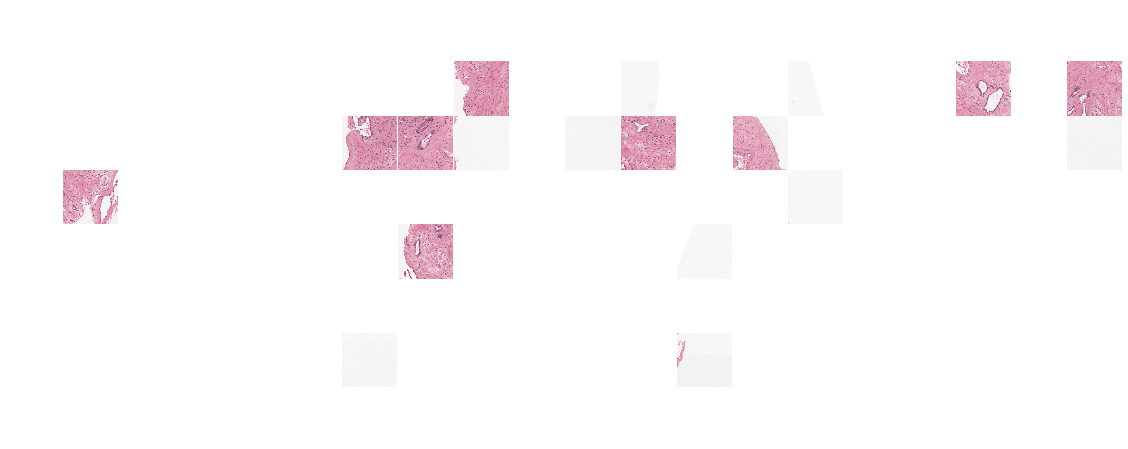